# Distributed Algorithms: || k-means
## <span style="color:green">1st notebook</span>
### <span style="color:blue">Group 20: Dall'Ara, Verguizaz I Moliner</span>

###  <span style="color:red">Introduction to k-means:</span>


K-means clustering is a widely used unsupervised machine learning algorithm that aims to partition a given dataset into distinct groups, known as clusters. The fundamental principle behind k-means is to assign data points to clusters in a way that minimizes the sum of squared distances between each point and the centroid of its assigned cluster. The algorithm iteratively refines these assignments and updates cluster centroids until convergence is achieved.

**K-Means Algorithm:**
1. Initialize the number of clusters (k) and randomly select k initial centroids from the dataset.
2. Assign each data point to the nearest centroid, forming k clusters.
3. Calculate the new centroids of each cluster by taking the mean of all data points assigned to it.
4. Repeat steps 2 and 3 until convergence criteria are met (e.g., centroids do not change significantly or a maximum number of iterations is reached).
5. The algorithm converges when the centroids stabilize, and each data point remains in the same cluster during successive iterations.


While traditional k-means has proven effective, it is sensitive to the initial placement of cluster centroids. Poor initializations can lead to suboptimal solutions, where the algorithm converges to local minima rather than the global minimum of the objective function. This limitation gave rise to an improved initialization technique known as k-means++.



###  <span style="color:red">Introduction to k-means ++:</span>



K-means++ is an enhancement over traditional k-means that addresses the issue of initialization sensitivity. In k-means++, the initial centroids are chosen in a way that significantly improves the chances of finding a better global optimum. The algorithm proceeds as follows:

**K-Means++ Initialization:**

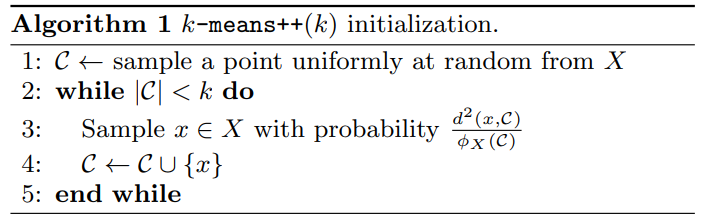

K-means++ initialization leads to faster convergence and more accurate clustering results compared to random initialization. However, even with improved initialization, the standard k-means algorithm can still be slow and inefficient for large datasets due to its sequential nature. This drawback gave rise to a parallelized version of k-means, known as "|| k-means."


###  <span style="color:red">Introduction to || k-means:</span>

Parallel k-means, denoted as "|| k-means," is a distributed version of the k-means algorithm designed to leverage the power of parallel computing and efficiently handle large-scale datasets. The goal of || k-means is to accelerate the convergence of k-means clustering by concurrently updating centroids on multiple processors or threads. This allows for quicker convergence and reduced computation time, making it well-suited for modern distributed computing environments.

**Parallel K-Means Initialization (|| K-Means):**

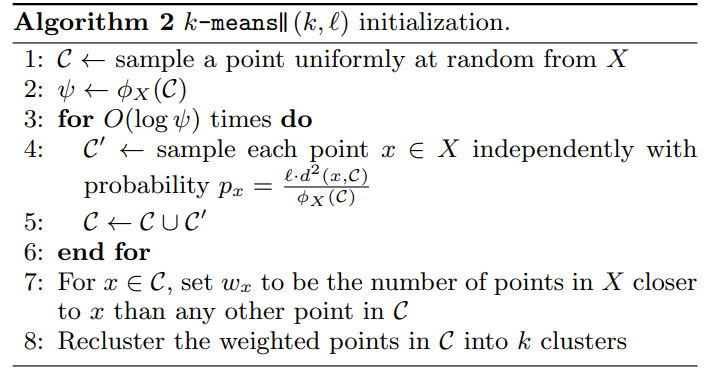



###  <span style="color:red">Non-distributed analysis</span>


We now implement k-means with three differents intializations: random, kmeans++ and || kmeans.


In [19]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt


def kmeans_random_init(X, k):
    
    """ Random initialization of k centroids elements of the given data X."""

    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, k, replace=False)]
    return centroids
    
    
def kmeans_Lloyd(X, centroids, k, max_iters=100, tol=1e-4):
    
    """ Run the sequential LLoyd algorithm given data X, centroids and k number of clusters."""

    costs = []

    for _ in range(max_iters):
        # Step 1: Assign each data point to the nearest centroid
        distances = euclidean_distances(X, centroids)
        labels = np.argmin(distances, axis=1)
        
        # Step 2: Update centroids based on the assigned points
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        
        # Calculate the cost function (sum of squared distances to centroids)
        cost = np.sum(np.min(distances, axis=1))
        costs.append(cost)

        
        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) <= tol:
            break
        
        centroids = new_centroids
    
    return centroids, labels, costs


def kmeans_pp(X, k):
    
    """ kmeans ++ initialization of k centroids elements. X is the data."""

    n_samples, n_features = X.shape
    centroids = np.empty((k, n_features))
    
    # K MEANS ++ INITIALIAZATION
    
    # Step 1: Choose one random point as the first centroid
    first_centroid_idx = np.random.choice(n_samples)
    centroids[0] = X[first_centroid_idx]
    
    for j in range(1, k):
        # Step 2: Compute squared distances from each point to the nearest centroid
        distances = np.min(euclidean_distances(X, centroids[:j])**2, axis=1)
        
        # Step 3: Choose the next centroid with probability proportional to squared distance
        probs = distances / np.sum(distances)
        next_centroid_idx = np.random.choice(n_samples, p=probs)
        centroids[j] = X[next_centroid_idx]
        
    return centroids    
    
    

def kmeans_ll(X, k, L, max_iters=100): 
    
    """ || kmeans initialization of k centroids elements. X is the data, L the oversampling factor."""

    
    n_samples, n_features = X.shape
    centroids = np.zeros((1, n_features))
    
    
    # Step 1: Choose one random point as the first centroid
    first_centroid_idx = np.random.choice(n_samples)
    centroids[0] = X[first_centroid_idx]
    
    psi = np.sum(euclidean_distances(X, [centroids[0]]))

    
    for j in range(1, int(np.log(psi))):

        # Step 2: Compute distances from each point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        distances = np.min(distances, axis=-1)


        # Step 3: Define probabilities
        probs = L * distances / np.sum(distances)
        
        # Sample and add centroids
        centroids = np.concatenate((centroids, X[np.random.rand(len(probs)) < probs]), axis=0)
                
    if len(centroids) > k:
                
        #A SORT OF K MEANS ++ INITIALIAZATION FOR Lloyd ITERATIONS ON CENTROIDS       
        c = np.copy(centroids)
        p_centroids = np.zeros((k, n_features))

        for j in range(0, k):
            
            # Define weights
            w = np.zeros(len(c))

            indexes = np.argmin(euclidean_distances(X, c), axis=1)

            for index in indexes:
                w[index] += 1

            probs = w / np.sum(w)
            next_centroid_idx = np.random.choice(len(probs), p=probs)
            p_centroids[j] = c[next_centroid_idx]
            c = np.delete(c, next_centroid_idx, axis=0)


        # K MEANS Lloyd ITERATIONS ON CENTROIDS

        centroids, __, _ = kmeans_Lloyd(centroids, p_centroids, k, max_iters)
        

    return centroids
    

Now we define Blobs data as example:

In [36]:
# Example usage for k-means

k = 3 # number of clusters
X, _ = make_blobs(n_samples=3000, n_features=2, centers=k, random_state=42, cluster_std=10.0)
max_iters = 100
max_iters_ll = 100
L = k


Now we run kmeans with || kmeans:

In [37]:
%time

init_ll_centroids = kmeans_ll(X,k,L,max_iters_ll)
final_ll_centroids, ll_cluster_labels, costll = kmeans_Lloyd(X, init_ll_centroids, k, max_iters)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


Now we run kmeans with random initializations:

In [38]:
%time

init_centroids = kmeans_random_init(X,k)
final_centroids, cluster_labels, costran = kmeans_Lloyd(X, init_centroids, k, max_iters)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


Now we run kmeans with kmeans ++:

In [39]:
%time

init_pp_centroids = kmeans_pp(X,k)
final_pp_centroids, pp_cluster_labels, costpp = kmeans_Lloyd(X, init_pp_centroids, k, max_iters)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


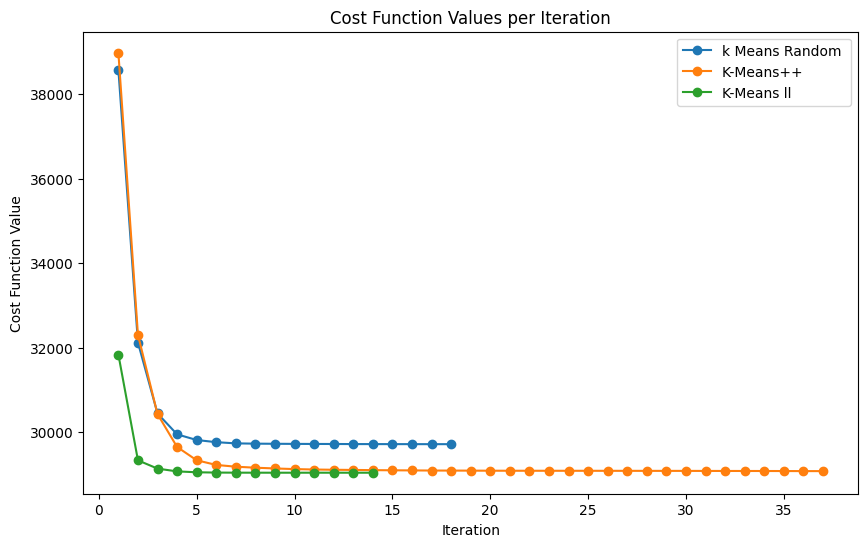

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(costran) + 1), costran, label='k Means Random ', marker='o')
plt.plot(range(1, len(costpp) + 1), costpp, label='K-Means++ ', marker='o')
plt.plot(range(1, len(costll) + 1), costll, label='K-Means ll ', marker='o')

plt.title('Cost Function Values per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost Function Value')
plt.legend()
plt.show()

This is an example where the execution times for the three algorithms are very similar, but we do not achieve optimal minima for k-means with random initialization.